In [1]:
%load_ext autoreload
%autoreload 2

In [389]:
import argparse
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import torch
import random
import pickle
import glob
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import json

import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data.data import Data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import config
import utils
import stanza
from networkx.drawing.nx_pydot import graphviz_layout

In [134]:
glove = {}
emb_file = config.GLOVE
with open(emb_file, 'r', encoding="utf-8") as fo:
    lines = fo.readlines()
    for line in tqdm(lines):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [136]:
print(glove["obama"][:6])
print(len(glove))
# to do handle OOV embedding

[-0.2028   0.44239  0.61904 -0.11624 -0.33635 -0.24591]
1917494


In [23]:
data_file=config.DEV_MA_FILE
emb=config.GLOVE
parser=None
save=False
target=config.PDEV_MA_FILE

In [36]:
with open(data_file) as fo:
    raw_lines = fo.readlines()
    json_data = [json.loads(line) for line in raw_lines]
print(json_data[0][config.idf])

63735n


In [219]:
glove["unk"]

array([ 9.8379e-01,  3.0920e-01, -2.1410e-01,  7.3205e-01,  7.0425e-01,
       -4.0901e-01,  3.1117e-01,  8.3661e-01, -5.4887e-01,  1.1810e-01,
       -7.9944e-02,  1.1999e-01, -5.7127e-01, -2.1187e-01,  4.7259e-01,
       -1.7222e-01,  2.4509e-01,  3.7258e-01,  7.2036e-02, -1.1110e-01,
        1.1536e-01, -5.0075e-02, -4.1218e-01,  2.6071e-01,  2.6072e-01,
        4.9735e-01,  2.8424e-01, -1.0520e-01, -2.0763e-01, -7.6100e-01,
        7.0592e-02, -1.4977e-01, -1.0003e-01, -6.9140e-01, -1.9006e-01,
        4.8052e-01, -3.3161e-01, -1.9765e-01,  2.1083e-04, -1.6365e-01,
       -1.3559e-01, -3.8407e-01,  9.3152e-03, -5.5862e-01,  2.7543e-01,
       -7.8948e-02,  1.3013e-01, -4.5273e-02, -1.8828e-01, -2.5038e-01,
       -1.2388e-01,  4.8664e-01, -1.2247e-01,  3.3745e-01, -2.5999e-01,
        5.1788e-01,  5.2841e-01,  2.6655e-01, -1.0299e+00, -6.9509e-01,
        2.2215e-01,  5.4446e-02,  6.8170e-01,  4.6204e-01,  1.6496e-01,
       -2.9798e-02, -1.5198e-01,  2.8922e-01,  1.7562e-01, -4.11

In [51]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2020-07-31 14:17:18 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-07-31 14:17:18 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2020-07-31 14:17:18 INFO: Use device: gpu
2020-07-31 14:17:18 INFO: Loading: tokenize
2020-07-31 14:17:18 INFO: Loading: pos
2020-07-31 14:17:19 INFO: Loading: lemma
2020-07-31 14:17:19 INFO: Loading: depparse
2020-07-31 14:17:21 INFO: Done loading processors!


In [76]:
doc = nlp("Barack Obama was born in Hawaii.  He was elected president in 2008.")
dir(doc)
stanza.download('zh')

2020-07-31 14:30:20 INFO: "zh" is an alias for "zh-hans"
2020-07-31 14:30:20 INFO: Downloading default packages for language: zh-hans (Simplified_Chinese)...
2020-07-31 14:37:41 INFO: Finished downloading models and saved to /root/stanza_resources.


In [69]:
dep_r = [line for line in dir(nlp(json_data[0][config.hf]).sentences[0]) if "dep" in line]
print(dep_r)

['_dependencies', 'build_dependencies', 'dependencies', 'dependencies_string', 'print_dependencies']


In [70]:
preprocessed_data = []
for data in json_data:
    #process_sentance()
    pass

In [97]:
utils.print_compact_dep(doc)

id: 1	word: Barack	head id: 4	head: born	deprel: nsubj:pass
id: 2	word: Obama	head id: 1	head: Barack	deprel: flat
id: 3	word: was	head id: 4	head: born	deprel: aux:pass
id: 4	word: born	head id: 0	head: root	deprel: root
id: 5	word: in	head id: 6	head: Hawaii	deprel: case
id: 6	word: Hawaii	head id: 4	head: born	deprel: obl
id: 7	word: .	head id: 4	head: born	deprel: punct
id: 1	word: He	head id: 3	head: elected	deprel: nsubj:pass
id: 2	word: was	head id: 3	head: elected	deprel: aux:pass
id: 3	word: elected	head id: 0	head: root	deprel: root
id: 4	word: president	head id: 3	head: elected	deprel: xcomp
id: 5	word: in	head id: 6	head: 2008	deprel: case
id: 6	word: 2008	head id: 3	head: elected	deprel: obl
id: 7	word: .	head id: 3	head: elected	deprel: punct


In [103]:
nlp(json_data[0][config.hf]).sentences[0].print_dependencies()

('Everyone', '3', 'nsubj')
('really', '3', 'advmod')
('likes', '0', 'root')
('the', '6', 'det')
('newest', '6', 'amod')
('benefits', '3', 'obj')


In [ ]:
nlp(json_data[0][config.hf]).sentences[0].print_dependencies()

In [168]:
from torch_geometric.data import Data

x = torch.tensor([[2,1],[5,6],[3,7],[12,0]],dtype=torch.float)

y = torch.tensor([[0,2,1,0,3],[3,1,0,1,2]],dtype=torch.long)

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [2, 1],
                           [0, 3],
                           [2, 3]], dtype=torch.long)
edge_index = edge_index.t() #IMP

data = Data(x=x,y=y,edge_index=edge_index)

In [160]:
data.is_directed()

True

In [210]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
def draw(data):
    G = to_networkx(data)
    nx.draw_circular(G, with_labels=True)
    plt.savefig("path.png")
    plt.show()

In [162]:
data.edge_index..tolist()

[[0, 1, 2, 0, 2], [1, 0, 1, 3, 3]]

In [163]:
type(data)

torch_geometric.data.data.Data

In [207]:
G = to_networkx(data, to_undirected=True)

In [270]:
s3_exp = "I am a dog. He is a dog. She is a cat."

In [292]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17))

dep's node attr = ? :  ['<ROOT>', 'Everyone', 'really', 'likes', 'the', 'newest', 'benefits']
Data(edge_attr=[6], edge_index=[2, 6], node_attr=[7], x=[7])
[0, 1, 2, 3, 4, 5, 6]
[(0, 3), (3, 1), (3, 2), (3, 6), (6, 4), (6, 5)]


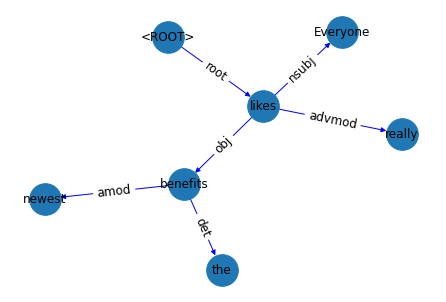

In [400]:
def draw(data, node_size=1000, font_size=12):
    G = to_networkx(data)
    pos = nx.nx_pydot.graphviz_layout(G)
    if(data.edge_attr != None):
        edge_labels = {(u,v):lab for u,v,lab in data.edge_attr}
    if(data.node_attr != None):
        node_labels = dict(zip(G.nodes, data.node_attr))
    nx.draw(G, pos=pos, nodecolor='r', edge_color='b', node_size=node_size, with_labels=False)
    nx.draw_networkx_labels(G, pos=pos, labels=node_labels, font_size=font_size)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels, font_size=font_size)
    print(G.nodes)
    print(G.edges)
    plt.savefig("path.png")
    
    plt.show()

def text2dep(s, nlp):
    """
    2020/8/3 18:30
    input (str:s, StanzaPipieline: nlp), s is of len l
    output (PytorchGeoData : G)
    G = {
     x: id tensor
     edge_idx : edges size = (2, l-1)
     edge_attr: (u, v, edge_type in str)
     node_attr: text
    }
    """
    doc = nlp(s)
    # add root token for each sentences
    x = torch.tensor(list(range(doc.num_tokens+len(doc.sentences))))
    #y = torch.tensor(list(range(doc.num_tokens+len(doc.sentences))))
    e = [[],[]]
    edge_info = []
    node_info = []
    prev_token_sum = 0
    prev_root_id = 0
    cur_root_id = 0
    # get original dependency
    for idx, sent in enumerate(doc.sentences):
        sent.print_dependencies
        # node info by index(add root at the beginning of every sentence)
        cur_root_id = len(node_info)
        node_info.append("<ROOT>")
        for token in sent.tokens:
            node_info.append(token.to_dict()[0]['text'])
        # edge info by index of u in edge (u,v)
        for dep in sent.dependencies:
            id1 = prev_token_sum + int(dep[0].to_dict()["id"])
            id2 = prev_token_sum + int(dep[2].to_dict()["id"])
            e[0].append(id1)
            e[1].append(id2)
            edge_info.append((id1, id2, dep[1]))
        prev_token_sum += len(sent.tokens)+1
        # add links between sentence roots
        if(cur_root_id != 0):
            id1 = prev_root_id
            id2 = cur_root_id
            e[0].append(id1)
            e[1].append(id2)
            edge_info.append((id1, id2, "bridge"))
        prev_root_id = cur_root_id
    # done building edges and nodes
    e = torch.tensor(e)
    G = Data(x=x, edge_index=e, edge_attr=edge_info, node_attr=node_info)
    return G

dep = text2dep(json_data[0][config.hf], nlp)
print("dep's node attr = ? : ", dep.node_attr)
print(dep)
draw(dep)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
[(0, 4), (0, 6), (4, 1), (4, 2), (4, 3), (4, 5), (6, 10), (6, 12), (10, 7), (10, 8), (10, 9), (10, 11), (12, 16), (16, 13), (16, 14), (16, 15), (16, 17)]


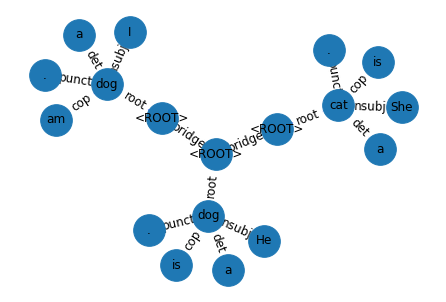

In [392]:
dep = text2dep(s3_exp, nlp)
draw(dep)

In [369]:
ANLI_example = "Kwon So-hyun (born August 30, 1994), is a South Korean singer and actress. She was known as a member of the South Korean girl group 4Minute, under Cube Entertainment. She is also a former member of the South Korean girl group, Orange. Before June 15, 2016 (end of her contract with Cube), Sohyun left 4Minute and the record label along with members Nam Ji-hyun, Heo Ga-yoon, and Jeon Ji-yoon."

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
[(0, 15), (0, 19), (1, 2), (1, 4), (4, 3), (4, 5), (5, 6), (5, 7), (5, 8), (5, 9), (15, 1), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 17), (15, 18), (17, 16), (19, 22), (19, 39), (22, 20), (22, 21), (22, 25), (22, 38), (25, 23), (25, 24), (25, 31), (25, 34), (25, 37), (31, 26), (31, 27), (31, 28), (31, 29), (31, 30), (31, 33), (33, 32), (37, 35), (37, 36), (39, 45), (39, 55), (45, 40), (45, 41), (45, 42), (45, 43), (45, 44), (45, 51), (45, 54), (50, 49), (51, 46), (51, 47), (51, 48), (51, 50), (51, 52), (51, 53), (55, 71), (57, 56), (57, 58), (57, 59), (57, 60), (57, 62), (62, 61), (62, 65), (62, 68), (65, 63

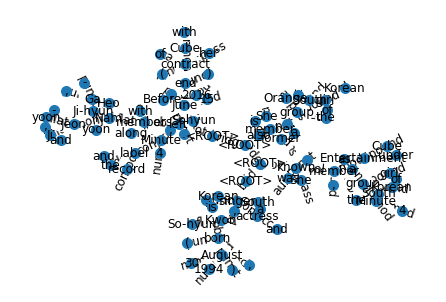

In [399]:
dep3 = text2dep(ANLI_example, nlp)
draw(dep3, node_size=100)

In [404]:
dep2 = text2dep(s3_exp, nlp)

In [405]:
G = to_networkx(dep2)

In [406]:
print(len(G.edges), len(G.nodes))

17 18


In [395]:
draw(dep2)

AttributeError: 'Data' object has no attribute 'node_attr'

In [228]:
doc2 = nlp(ANLI_example)
len(doc2.sentences)

4